# **Kellgren-Lawrance Image Classification with Vision Transformer (ViT)**

This notebook demonstrates the process of training a Vision Transformer (ViT) for binary image classification, utilizing a [**dataset**](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) from Kaggle. It covers data preprocessing, model creation, training, evaluation, and visualization of the model's decision-making process using Grad-CAM.

The key steps covered in this notebook include:

* **Dataset Download**: Downloading and preparing the dataset for training and evaluation.
* **Data Preprocessing**: Loading and preparing the dataset, including data modification and normalization.
* **Model Creation**: Building the Vision Transformer model, including defining the Multi-Layer Perceptron (MLP), Patch Extraction, and Patch Encoding layers.
* **Model Definition**: Compiling and defining the Vision Transformer model architecture.
* **Results**: Training and evaluating the model using various metrics such as accuracy, AUC, precision, recall, and F1 score, and visualizing important regions in the images influencing the model's predictions using Grad-CAM.


# **Useful modules import**
First of all, it is necessary to import useful modules used during the tutorial.

In [ ]:
# Install Keras version 3.*
!pip install keras==3.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.



Below are descriptions of the modules and libraries used in the notebook:

* `numpy` - Used for complex mathematical operations and handling multi-dimensional arrays.

* `matplotlib.pyplot` - Graphing library for data visualization.

* `tensorflow.keras.layers` - Module for defining neural network layers in the TensorFlow framework.

* `pandas` - Library for data manipulation and analysis.

* `random` - Module for generating random numbers.

* `time` - Module for manipulating times and dates.

* `glob` - Module for finding all paths that match a specific pattern.

* `os` - Module for interacting with the operating system.

* `cv2 (OpenCV)` - Library for processing images and videos.

* `sklearn.model_selection.train_test_split` - Function to split data into training and test sets.

* `tensorflow` e `tensorflow.keras` - Frameworks for machine learning and deep learning.

* `tensorflow.keras.backend` - Provides access to backend-specific functions of Keras.

* `tensorflow.keras.utils` - Utility functions for Keras.

* `keras.layers` e `keras.ops` - Keras modules for defining operations and neural network layers.

* `jax` - Library for high-performance numerical computations.

* `tensorflow.keras.optimizers.AdamW` - Adam optimizer with weight decay.

* `tensorflow.keras.metrics.CategoricalAccuracy`, `Precision`, `Recall`, `AUC` - Metrics for evaluating the performance of classification models.

* `tensorflow.keras.callbacks.ModelCheckpoint`, `EarlyStopping` - Callbacks for saving the best weights and early stopping of training.

* `IPython.display.Image`, `display` - Functions to display images and outputs in notebooks.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
import pandas as pd
import random
import time
import glob
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras import ops
import jax
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import Image, display
import cv2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Utility Functions**

* **countImages**: Iterates through subfolders for each grade (0-4) and counts the number of images present in each.
* **searchForPairImgs**: Randomly selects a grade and image index, then searches for a matching image in the test and auto_test folders based on the filename and side (R or L).
* **load_image**: Uses OpenCV to load an image and converts the color space from BGR to RGB since OpenCV loads images in BGR by default.

In [ ]:
# Function to count images in each grade folder
def countImages(path):
  cont = [0]*5

  for grades in range(5):
    cont[grades] = len(glob.glob(path + f'{grades}/*.png'))

  return cont

# Function to search for a pair of matching images in test and auto_test folders
def searchForPairImgs():
    images = ['', '']
    while not all(images):
        random_grade = random.randint(0, 4)
        random_idx = random.randint(0, test[random_grade] - 1)
        img_test = glob.glob(f'/content/test/{random_grade}/*.png')
        img_autotest = glob.glob(f'/content/auto_test/{random_grade}/*.png')
        test_name = os.path.basename(img_test[random_idx])[:7]
        test_side = '1' if os.path.basename(img_test[random_idx])[7] == 'R' else '2'
        for img in img_autotest:
            if os.path.basename(img)[:-6] == test_name and os.path.basename(img)[8] == test_side:
                images = [img_test[random_idx], img]
    return images

# Function to load and convert images
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# **Dataset**

The [**Knee Osteoarthritis Dataset with Severity Grading**](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity), containing X-ray images of knee joints with varying degrees of osteoarthritis severity, will be used.

The following code loads the dataset into memory.

## **Dataset Download**

Below is the code to download the dataset from Kaggle. This includes the following operations:

- Installation of necessary libraries, such as kaggle, opendatasets, and Pillow;
- Loading the JSON file with the Kaggle token;
- Creation of the necessary directory to download the dataset from Kaggle. The file with the token is copied into the directory with read and write permissions;
- Download of the dataset;
- Unzipping the dataset and deleting the .zip file;

In [ ]:
# Install necessary libraries for dataset download
!pip install kaggle
!pip install opendatasets
!pip install Pillow

In [ ]:
# CELLA 4

# Load Kaggle token
from google.colab import files
files.upload()

# Create directory for Kaggle configuration and copy the token file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity

# Unzip the dataset
!unzip -q knee-osteoarthritis-dataset-with-severity.zip

# Remove the zip file
!rm /content/knee-osteoarthritis-dataset-with-severity.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 199M/204M [00:01<00:00, 109MB/s]
100% 204M/204M [00:01<00:00, 110MB/s]


## **Dataset Cardinality**

The "*Knee Osteoarthritis Dataset with Severity*" on Kaggle contains X-ray images of knees, classified into 5 distinct grades (0-4) representing the absence or presence and severity of osteoarthritis. This code defines the number of classes (5) and uses the `countImages` function to count and print the total and per-grade number of images in the training, validation, test, and auto-test folders. This process helps to understand the distribution of images in the dataset and prepare the data for model training.

In [ ]:
# Define number of classes
num_classes = 5

# Count images in each folder
train = countImages('/content/train/')
val = countImages('/content/val/')
test = countImages('/content/test/')
auto_test = countImages('/content/auto_test/')

# Print total and per-grade counts of images in each folder
print(f'Total cardinality of the train folder: {sum(train)}')
[print(f'   Images of grade {grades}: {train[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the val folder: {sum(val)}')
[print(f'   Images of grade {grades}: {val[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the test folder: {sum(test)}')
[print(f'   Images of grade {grades}: {test[grades]}') for grades in range(5)]
print('')
print(f'Total cardinality of the auto-test folder: {sum(auto_test)}')
[print(f'   Images of grade {grades}: {auto_test[grades]}') for grades in range(5)]
print('')

Total cardinality of the train folder: 5778
   Images of grade 0: 2286
   Images of grade 1: 1046
   Images of grade 2: 1516
   Images of grade 3: 757
   Images of grade 4: 173

Total cardinality of the val folder: 826
   Images of grade 0: 328
   Images of grade 1: 153
   Images of grade 2: 212
   Images of grade 3: 106
   Images of grade 4: 27

Total cardinality of the test folder: 1656
   Images of grade 0: 639
   Images of grade 1: 296
   Images of grade 2: 447
   Images of grade 3: 223
   Images of grade 4: 51

Total cardinality of the auto-test folder: 1526
   Images of grade 0: 604
   Images of grade 1: 275
   Images of grade 2: 403
   Images of grade 3: 200
   Images of grade 4: 44



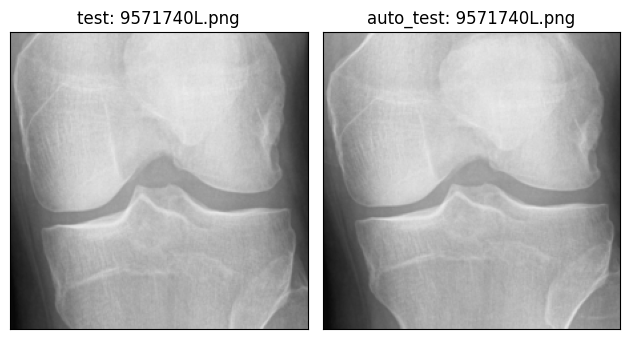

In [ ]:
# CELLA 6

# Search for a pair of matching images in test and auto_test folders
path_test, path_autotest = searchForPairImgs()

# Load the images
img_test = cv2.imread(path_test)
img_autotest = cv2.imread(path_autotest)

# Display the images side by side
fig, axes = plt.subplots(1, 2)
for ax, img, title in zip(axes, [img_test, img_autotest], ['test', 'auto_test']):
    ax.imshow(img)
    ax.set_title(title + ': ' + os.path.basename(path_test))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# Define paths for different data folders
data_paths = ['/content/train', '/content/test', '/content/val'] #Test without '/content/auto_test'

# Initialize list to store image paths and their corresponding classes
image_class_pairs = []

# Get image paths and classes within subdirectories
for data_path in data_paths:
    for sub_data_path in glob.glob(data_path + '/*'):
        class_name = sub_data_path.split('/')[-1]

        image_paths = glob.glob(sub_data_path + '/*.png')

        if image_paths:
            for image_path in image_paths:
                image_class_pairs.append((image_path, class_name))

# Print unique classes and the number of images
print("Classes:", set(class_name for _, class_name in image_class_pairs))
print("Number of images:", len(image_class_pairs))

# Normalize paths and shuffle the pairs
image_class_pairs = [(path.replace('\\', '/'), cls) for path, cls in image_class_pairs]
random.shuffle(image_class_pairs)

Classes: {'1', '3', '0', '2', '4'}
Number of images: 8260


# **Creating Training, Validation and Test Sets and Dataset Preparation**

This code shuffles the dataset and splits it into **training**, **validation**, and **test** sets based on predefined proportions.

These proportions are chosen to ensure that there is enough data for the model to learn effectively (training set), validate the model during training to tune hyperparameters (validation set), and finally evaluate the model's performance on unseen data (test set).

In [ ]:
# Define train, validation, and test splits
train_split, val_split, test_split = 0.7, 0.15, 0.15

# Calculate number of samples for each split
num_samples = len(image_class_pairs)
num_train = int(train_split * num_samples)
num_val = int(val_split * num_samples)
num_test = int(test_split * num_samples)

# Split the image_class_pairs into train, validation, and test sets
train_image_class_pairs = image_class_pairs[:num_train]
val_image_class_pairs = image_class_pairs[num_train:num_train + num_val]
test_image_class_pairs = image_class_pairs[num_train + num_val:]

# Separate the paths and classes for each set
train_image_paths, train_y = zip(*train_image_class_pairs)
val_image_paths, val_y = zip(*val_image_class_pairs)
test_image_paths, test_y = zip(*test_image_class_pairs)

# Print the sizes of the resulting splits
print("Train size:", len(train_image_paths))
print("Validation size:", len(val_image_paths))
print("Test size:", len(test_image_paths))

# Optionally print examples
print('Example train image path:', train_image_paths[1])
print('Example train class:', train_y[1])

Train size: 5782
Validation size: 1239
Test size: 1239
Example train image path: /content/train/1/9723575R.png
Example train class: 1


Sets the Keras backend to JAX and prints the versions and device info.

In [ ]:
# Set Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

# Print versions and device info
print("Keras version:", keras.__version__)
print("JAX version:", jax.__version__)
print("Device:", jax.devices())

Keras version: 3.4.1
JAX version: 0.4.26
Device: [cuda(id=0)]


Defines the number of classes and input shape. Loads images and labels for training, validation, and test sets. Converts data to numpy arrays and prints the shapes of the arrays.

In [ ]:
# Define number of classes and input shape
num_classes = 5
input_shape = (224, 224, 3)

# Load images and labels for train, validation, and test sets
train_images = [load_image(path) for path in train_image_paths]
train_labels = [int(label) for label in train_y]

val_images = [load_image(path) for path in val_image_paths]
val_labels = [int(label) for label in val_y]

test_images = [load_image(path) for path in test_image_paths]
test_labels = [int(label) for label in test_y]

# Convert data to numpy arrays
x_train = np.array(train_images)
y_train = np.array(train_labels).reshape(-1, 1)

x_val = np.array(val_images)
y_val = np.array(val_labels).reshape(-1, 1)

x_test = np.array(test_images)
y_test = np.array(test_labels).reshape(-1, 1)

# Print shapes of the arrays
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Print the shape of the first training image
train_images[0].shape

x_train shape: (5782, 224, 224, 3) - y_train shape: (5782, 1)
x_val shape: (1239, 224, 224, 3) - y_val shape: (1239, 1)
x_test shape: (1239, 224, 224, 3) - y_test shape: (1239, 1)


(224, 224, 3)

In [ ]:
train_images[0].shape

(224, 224, 3)

# **Data Preprocessing**

* **`crop_image`**: This function takes an image as input and crops it by removing 57 pixels from the top and bottom. It then applies cropping to all images in the training, validation, and test sets. The new shape of the images after cropping is printed.

* **`display_random_cropped_images`**: This function displays 5 random cropped images from the training set to visually check the result of the cropping.

* **`equalize_image`**: This function equalizes the histogram of the images by first converting them to YUV, equalizing the luminance channel (Y), and then converting the image back to RGB. The equalization is applied to all images in the training, validation, and test sets. The new shape of the images after equalization is printed.

* **`display_random_equalized_images`**: Although not explicitly in the code, it can be assumed that the **`display_random_cropped_images`** function is reused to display 5 random equalized images from the training set to visually check the result of the equalization.

* **Updating input shape**: After cropping and equalization, the input shape is updated to reflect the new image dimensions (110, 224, 3). The updated input shape is printed.

* **`data_modification`**: A Keras sequential model is defined that includes normalization and resizing layers to adjust the images to the desired dimensions (36, 72). The normalization layer is adapted to the training data to calculate the mean and variance. A confirmation of the normalization layers' adaptation is printed.


## **Image Cropping**

In [ ]:
# Function to crop images
def crop_image(image):
    return image[57:-57, :]

# Apply cropping to all images
x_train = np.array([crop_image(img) for img in x_train])
x_val = np.array([crop_image(img) for img in x_val])
x_test = np.array([crop_image(img) for img in x_test])

# Print shapes after cropping
print(f"x_train shape after cropping: {x_train.shape}")
print(f"x_val shape after cropping: {x_val.shape}")
print(f"x_test shape after cropping: {x_test.shape}")

x_train shape after cropping: (5782, 110, 224, 3)
x_val shape after cropping: (1239, 110, 224, 3)
x_test shape after cropping: (1239, 110, 224, 3)


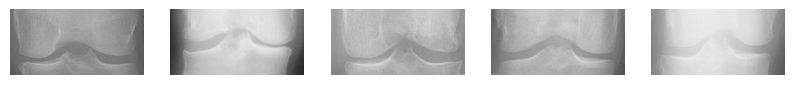

In [ ]:
# Function to display 5 random cropped images
def display_random_cropped_images(images, titles=None):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        idx = np.random.randint(0, len(images))
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        if titles:
            plt.title(titles[idx])
        plt.axis("off")
    plt.show()

# Display 5 random cropped images from the training set
display_random_cropped_images(x_train)

## **Image Equalization**

In [ ]:
# Function to equalize images
def equalize_image(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# Apply equalization to all images
x_train = np.array([equalize_image(img) for img in x_train])
x_val = np.array([equalize_image(img) for img in x_val])
x_test = np.array([equalize_image(img) for img in x_test])

# Print shapes after equalization
print(f"x_train shape after equalization: {x_train.shape}")
print(f"x_val shape after equalization: {x_val.shape}")
print(f"x_test shape after equalization: {x_test.shape}")

x_train shape after equalization: (5782, 110, 224, 3)
x_val shape after equalization: (1239, 110, 224, 3)
x_test shape after equalization: (1239, 110, 224, 3)


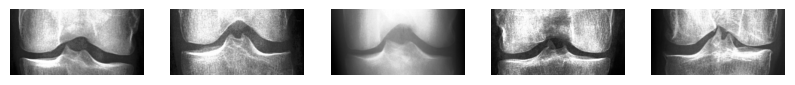

In [ ]:
# Display 5 random equalized images from the training set
display_random_cropped_images(x_train)

In [ ]:
# Update input shape after cropping and equalization
input_shape = (110, 224, 3)

# Print the updated input shape
print(f"Updated input_shape: {input_shape}")

Updated input_shape: (110, 224, 3)


## **Data Modification**

In [ ]:
image_size = (36, 72)  # Size of resized images, maintaining aspect ratio
patch_size = 6  # Size of the patches to be extracted from the input images

# Define a sequential model for data normalization and resizing
data_modification = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size[0], image_size[1]),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_modification",
)

# Adapt normalization layer to the training data
data_modification.layers[0].adapt(x_train)

# Print confirmation that the layers are adapted
print("Data Modification layers adapted to the training data.")

Data Modification layers adapted to the training data.


# **Model Creation**

These steps are important for standardizing the input images and enhancing their quality, which helps improve the performance and accuracy of the model. Cropping removes unwanted borders, equalization adjusts the contrast, and normalization and resizing ensure the images are in a consistent format suitable for the neural network.

* **`crop_image`**: This function takes an image as input and crops it by removing 57 pixels from the top and bottom. It then applies cropping to all images in the training, validation, and test sets. The new shape of the images after cropping is printed.

* **`display_random_cropped_images`**: This function displays 5 random cropped images from the training set to visually check the result of the cropping.

* **`equalize_image`**: This function equalizes the histogram of the images by first converting them to YUV, equalizing the luminance channel (Y), and then converting the image back to RGB. The equalization is applied to all images in the training, validation, and test sets. The new shape of the images after equalization is printed.

* **`display_random_equalized_images`**: Although not explicitly in the code, it can be assumed that the **`display_random_cropped_images`** function is reused to display 5 random equalized images from the training set to visually check the result of the equalization.

* **Updating input shape**: After cropping and equalization, the input shape is updated to reflect the new image dimensions (110, 224, 3). The updated input shape is printed.

* **`data_modification`**: A Keras sequential model is defined that includes normalization and resizing layers to adjust the images to the desired dimensions (36, 72). The normalization layer is adapted to the training data to calculate the mean and variance. A confirmation of the normalization layers' adaptation is printed.


## **Multilayer Perceptron (MLP)**

The MLP used here consists of dense layers and dropout layers. Dense (fully connected) layers are used to learn non-linear representations of the data, while dropout layers help prevent overfitting.

In [ ]:
# CELLA 17

# Define a function to create a Multilayer Perceptron (MLP) with specified hidden units and dropout rate
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## **Patch Creation layer**

The `Patches` class is used to divide an image into small patches. Each patch is a small region of the image that will be processed individually by the model. This approach helps the model capture local details and reduces computational complexity.

In [ ]:
# Define a class for creating patches from images
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

### Sample Image Visualization

This cell displays a sample image and its patches. The images are resized and divided into patches to visually verify that the patch creation process works correctly.



Image shape: (110, 224, 3)
Image size: 36 X 72
Patch size: 6 X 6
Patches per image: 72
Elements per patch: 108


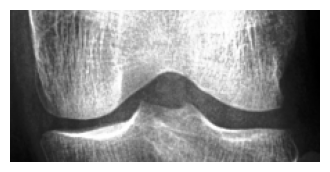

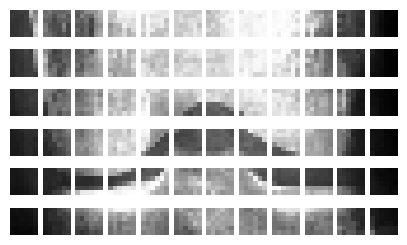

In [ ]:
# Display a sample image and its patches
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
print("Image shape:", image.shape)
plt.imshow(image.astype("uint8"))
plt.axis("off")

# Resize the image and create patches
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size[0], image_size[1])
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size[0]} X {image_size[1]}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Calculate the number of patches per row and column
num_patches_h = image_size[0] // patch_size
num_patches_w = image_size[1] // patch_size

# Display the patches
plt.figure(figsize=(5, 3))
for i, patch in enumerate(patches[0]):
    row = i // num_patches_w
    col = i % num_patches_w
    ax = plt.subplot(num_patches_h, num_patches_w, row * num_patches_w + col + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")
plt.show()


### Analysis of Image Patch Division

The resized 36x72 pixel image is divided into 72 patches, each 6x6 pixels. This division creates a grid of 6x12 patches (36/6 = 6 rows, 72/6 = 12 columns), covering the entire image without overlaps.
The image shows the 72 generated patches, arranged in 6 rows and 12 columns below the original image. Each patch contains 108 elements because:
- Each patch is 6x6 pixels = 36 pixels
- There are 3 color channels (RGB) per pixel
- Thus, 36 pixels x 3 channels = 108 elements per patch


#### Deductions on Effectiveness
This patch division can make image processing more effective for several reasons:
1. *Captures local details*: Each patch represents a specific area of the image, allowing the model to focus on local features.
2. *Reduces complexity*: Analyzing small patches is computationally more efficient than processing the entire high-resolution image.
3. *Facilitates learning spatial relationships*: The model can learn how different parts of the image relate to each other.
4. *Increases robustness*: The model becomes less sensitive to small variations or shifts in the image.

## **Patch Encoding layer**


The `PatchEncoder` class is responsible for encoding patches with linear projections and positional embeddings. The linear projection maps each patch to a fixed-dimensional space, while positional embeddings add information about the position of each patch within the image. This is crucial for maintaining spatial information in the model.

In [ ]:
# Define a class for encoding patches with position embeddings
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# **Model Definition**

A **Vision Transformer (ViT)** is a type of deep learning model designed for image classification tasks. Unlike traditional convolutional neural networks (CNNs) that use convolutional layers to process images, **ViT** uses the transformer architecture originally designed for natural language processing (NLP). **ViT** splits an image into fixed-size patches, linearly embeds each of them, and then processes them as a sequence of embeddings through transformer layers. This approach allows **ViT** to capture long-range dependencies in images more effectively than CNNs

**Model Composition Highlights:**
* **Multi-Layer Perceptron (MLP)**: The function mlp creates a multi-layer perceptron used in the transformer layers for non-linear transformations and feature extraction. It consists of dense layers with activation and dropout.
* **Patch Extraction (Patches Layer)**: The class class Patches is responsible for dividing the input image into smaller fixed-size patches. This step transforms the 2D image into a sequence of patches that can be processed by the transformer.
* **Patch Encoding (PatchEncoder Layer)**: The class class PatchEncoder projects the patches into a higher-dimensional space and adds positional embeddings. This step ensures that the spatial information of the patches is preserved and effectively utilized by the transformer layers.


This is an example image to describe the structure:


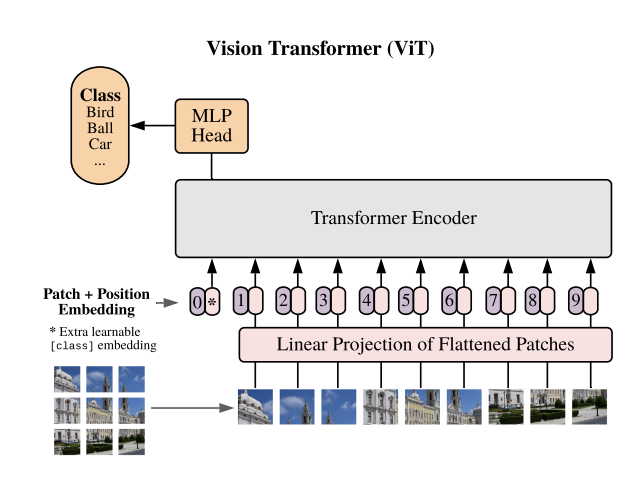


## **Hyperparameters Configurations**

This code sets up and prints various hyperparameters and configurations needed for training a transformer-based model on image data. These parameters include learning rate, batch size, image size, patch size, and the architecture details for the transformer and the final classifier.

* `learning_rate`: The step size used by the optimizer to update model weights during training.
* `weight_decay`: A regularization parameter to prevent overfitting by penalizing large weights.
batch_size: The number of samples processed before the model is updated.
* `num_epochs`: The number of complete passes through the training dataset.
image_size: The dimensions to which input images will be resized.
* `patch_size`: The dimensions of patches extracted from the resized images.
num_patches: The total number of patches derived from an image, based on the image and patch sizes.
* `projection_dim`: The dimension of the vector to which each patch is projected.
num_heads: The number of attention heads in the transformer model.
* `transformer_units`: The sizes of the hidden layers in the transformer block.
transformer_layers: The number of transformer layers in the model.
* `mlp_head_units`: The sizes of the hidden layers in the Multi-Layer Perceptron (MLP) head of the model.

Changing these hyperparameters can significantly affect the model's performance. For instance, a higher learning rate might speed up training but could lead to instability, while a lower learning rate might make training slower but more stable. Adjusting the batch size can affect the convergence speed and generalization of the model

In [ ]:
# Set hyperparameters for the Vision Transformer (ViT) model
learning_rate = 0.001
weight_decay = 0.001
batch_size = 256
num_epochs = 100

num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]

# Print the hyperparameters
print(f"learning_rate: {learning_rate}")
print(f"weight_decay: {weight_decay}")
print(f"batch_size: {batch_size}")
print(f"num_epochs: {num_epochs}")
print(f"image_size: {image_size}")
print(f"patch_size: {patch_size}")
print(f"num_patches: {num_patches}")
print(f"projection_dim: {projection_dim}")
print(f"num_heads: {num_heads}")
print(f"transformer_units: {transformer_units}")
print(f"transformer_layers: {transformer_layers}")
print(f"mlp_head_units: {mlp_head_units}")

learning_rate: 0.001
weight_decay: 0.001
batch_size: 256
num_epochs: 100
image_size: (36, 72)
patch_size: 6
num_patches: 72
projection_dim: 64
num_heads: 4
transformer_units: [128, 64]
transformer_layers: 8
mlp_head_units: [2048, 1024]


## **Build the ViT model**

This section defines a function to create a Vision Transformer (ViT) classifier model. The process involves:

1. **Input Layer**: Defines the input layer with the specified input shape.
2. **Data Normalization and Resizing**: Applies normalization and resizing to the inputs.
3. **Patch Extraction**: Extracts non-overlapping patches from the augmented images.
4. **Patch Encoding**: Encodes patches with positional embeddings to retain spatial information.
5. **Transformer Layers**: Applies multiple transformer layers consisting of multi-head attention, layer normalization, MLP, and skip connections.
6. **Representation Layer**: Normalizes, flattens, and applies dropout to the final encoded patches.
7. **MLP Head**: Adds an MLP head with dropout for feature extraction.
8. **Classification Layer**: Adds a dense layer with softmax activation for multi-class classification.


In [ ]:
# Define a function to create the Vision Transformer (ViT) classifier model
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_modification(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

vit_classifier = create_vit_classifier()

## **Model Visualization**

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vit_classifier, show_shapes=True, show_layer_names=True, expand_nested=True)

Output hidden; open in https://colab.research.google.com to view.

## **Load Model**

This code loads the previously saved model weights from a specified path.



In [ ]:
"""
# Save model weights to Google Drive

weights_save_path = '/content/drive/My Drive/VIT_9k.weights.weights.h5'

vit_classifier.save_weights(weights_save_path)

print(f'Weights saved to {weights_save_path}')
"""

## **Model Compile**

This code defines a function to compile the model, specifying the optimizer, loss function, and evaluation metrics.

In [ ]:
# Define a custom F1Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define a function to compile the model with specified optimizer, loss function, and metrics
def compile_model(model):
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.001)
    metrics = [
        CategoricalAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', curve="ROC"),
        F1Score()
    ]
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model

## **Model Train**

In this section, we define a function to train the Vision Transformer (ViT) classifier model and then create, compile, and train the model using the training and validation datasets. The training process includes callbacks for saving the best model weights and early stopping to prevent overfitting. After training, the model is evaluated on the test dataset to determine its performance.


In [ ]:
# Define a function to train the model
def train_model(model, x_train, y_train, x_val, y_val, x_test, y_test, batch_size, epochs):
    y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
    y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
    y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train_one_hot,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val_one_hot),
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    model.load_weights(checkpoint_filepath)
    results = model.evaluate(x_test, y_test_one_hot)
    print(f"Test results - Loss: {results[0]} Accuracy: {results[1]}")
    print(f"Precision: {results[2]} Recall: {results[3]} AUC: {results[4]}")
    print(f"F1-score: {results[5]}")

    return history


In [ ]:
# Create the Vision Transformer (ViT) classifier model
vit_classifier = create_vit_classifier()

# Compile the model
vit_classifier = compile_model(vit_classifier)

# Train the model
history = train_model(vit_classifier, x_train, y_train, x_val, y_val, x_test, y_test, batch_size, num_epochs)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 350ms/step - accuracy: 0.2948 - auc: 0.6023 - f1_score: 0.2444 - loss: 5.3449 - precision: 0.3007 - recall: 0.2098 - val_accuracy: 0.4084 - val_auc: 0.7295 - val_f1_score: 0.0143 - val_loss: 1.3905 - val_precision: 0.5294 - val_recall: 0.0073
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.3514 - auc: 0.6993 - f1_score: 0.1656 - loss: 1.4803 - precision: 0.3755 - recall: 0.1066 - val_accuracy: 0.4060 - val_auc: 0.7389 - val_f1_score: 0.1302 - val_loss: 1.3689 - val_precision: 0.6250 - val_recall: 0.0726
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.3739 - auc: 0.7146 - f1_score: 0.1578 - loss: 1.4172 - precision: 0.4516 - recall: 0.0957 - val_accuracy: 0.4374 - val_auc: 0.7537 - val_f1_score: 0.0753 - val_loss: 1.3374 - val_precision: 0.5618 - val_recall: 0.0404
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.3874 - auc: 0.7311 - f1_score: 0.1944 - loss: 1.3746 - precision: 0.5012 - r

## **Weight Saving**

In [ ]:
"""
# Save model weights to Google Drive
weights_save_path = '/content/drive/My Drive/VIT_9k.weights.h5'
vit_classifier.save_weights(weights_save_path)
print(f'Weights saved to {weights_save_path}')
"""

"\n# CELLA 28\n\n# Save model weights to Google Drive\nweights_save_path = '/content/drive/My Drive/VIT_9k.weights.h5'\nvit_classifier.save_weights(weights_save_path)\nprint(f'Weights saved to {weights_save_path}')\n"

# **Results**

In this section, we use several metrics to evaluate the performance of our binary classification model. The chosen metrics help us better understand how the model performs in different aspects of classification. Here is a list of the metrics used and their importance:

* **Accuracy**: Represents the proportion of correct predictions out of the total predictions. It is a general metric that indicates how often the model makes the right prediction.

* **AUC (Area Under the Curve)**: Measures the model's ability to distinguish between classes. A higher AUC indicates a better ability of the model to discriminate between positive and negative classes.

* **Precision**: Indicates the proportion of correct positive predictions out of the total positive predictions. It is important in scenarios where false positives have a high cost.

* **Recall**: Represents the proportion of correct positive predictions out of the total actual positives. It is crucial in contexts where capturing all positives is essential, even at the cost of some false positives.

* **F1 Score**: It is the harmonic mean of precision and recall. It provides a balance between precision and recall and is useful when a compromise between the two is needed.

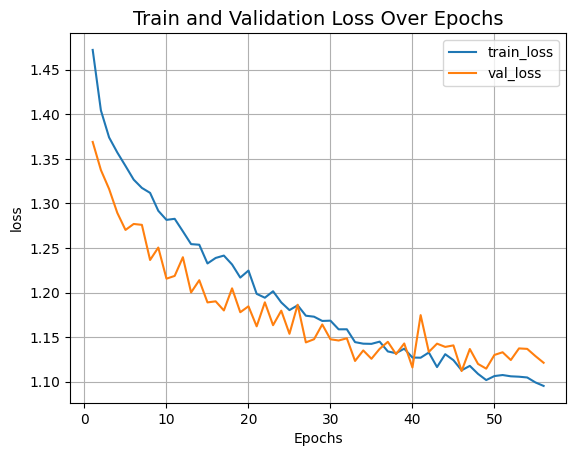

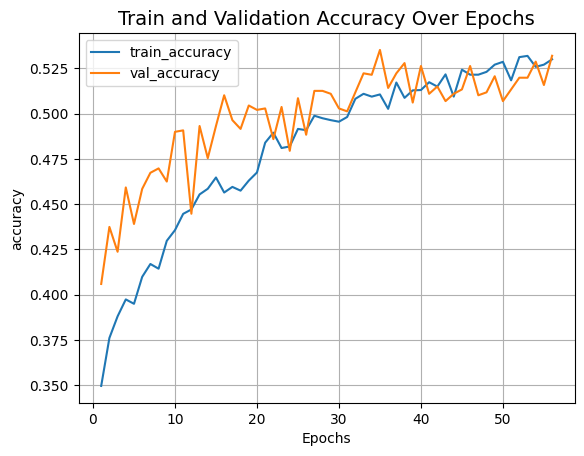

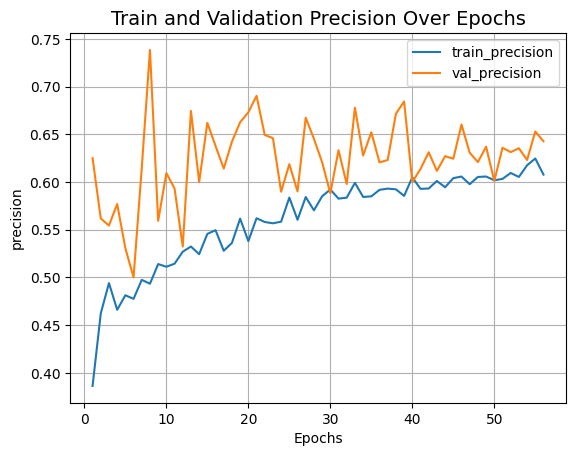

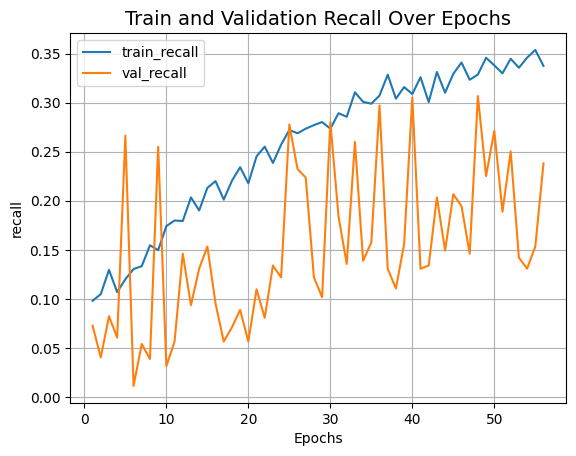

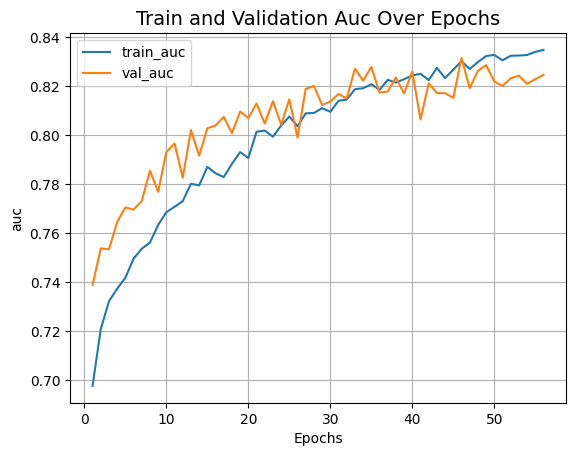

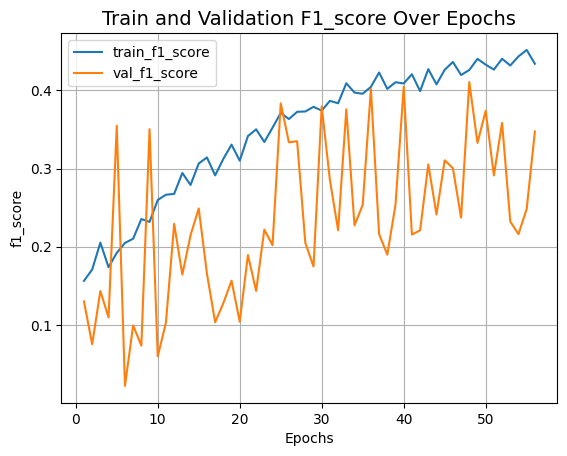

In [ ]:
# Define a function to plot training and validation metrics starting from the second epoch
def plot_history(history, metrics):
    epochs = range(1, len(history.history[metrics[0]]))
    for metric in metrics:
        plt.plot(epochs, history.history[metric][1:], label=f'train_{metric}')
        plt.plot(epochs, history.history[f'val_{metric}'][1:], label=f'val_{metric}')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(f"Train and Validation {metric.capitalize()} Over Epochs", fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

# Define metrics to plot
metrics_to_plot = ["loss", "accuracy", "precision", "recall", "auc", "f1_score"]
plot_history(history, metrics_to_plot)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


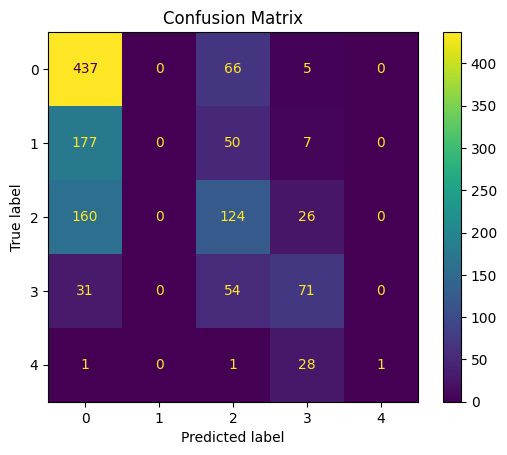

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels on the test set
y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

## **Grad-Cam**


**Grad-CAM** (Gradient-weighted Class Activation Mapping) is a visualization technique used to understand and interpret the decisions made by deep learning models, particularly convolutional neural networks (CNNs). Grad-CAM provides a heatmap that highlights the regions of an image that were most important for the model's prediction. Here is a list of what Grad-CAM does and why it is useful:

*What Grad-CAM does:*

* **Generates Heatmaps**: Uses the gradients flowing backward from the model's output through the last convolutional layers to generate a weighted activation map. This map shows which parts of the image contributed most to the final decision.
* **Highlights Important Regions**: The heatmap overlaid on the original image highlights the areas that the model considers most relevant for classification.

*Why we used Grad-CAM:*

* **Model Interpretability**: Grad-CAM helps visualize and understand the model's internal workings, allowing us to see which features of the image the model focused on to make a prediction.
* **Debugging and Reliability**: Using Grad-CAM, we can verify if the model is making decisions based on relevant features and not on artifacts or noise. This is particularly important to ensure the model is reliable and robust.
* **Communication with Non-Experts**: Grad-CAM heatmaps are useful for explaining the model's decisions to people who are not experts in deep learning, improving transparency and trust in the model.



In [ ]:
# Set Keras backend to TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

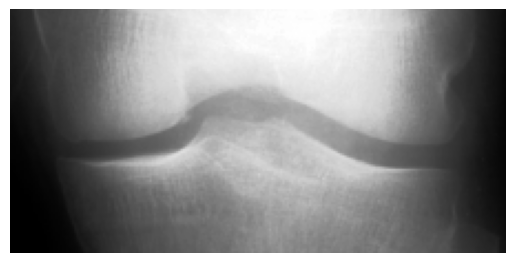

In [ ]:
# Function to load and preprocess an image
def gradcam_load_and_preprocess_image_for(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[57:-57, :]
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img

# Load and preprocess a test image
img_path = test_image_paths[0]
img = gradcam_load_and_preprocess_image_for(img_path)

# Display the preprocessed image
plt.imshow(img)
plt.axis('off')
plt.show()

# Convert image to array and add batch dimension
img_array = np.expand_dims(img, axis=0)

# Specify the relevant layer for Grad-CAM
last_conv_layer_name = "dense"

This cell contains two main functions: `get_img_array` and `make_gradcam_heatmap`.

1. **`get_img_array`**: This function loads and preprocesses an image using the `gradcam_load_and_preprocess_image_for` function, then adds a batch dimension to make the image compatible with the model input.

2. **`make_gradcam_heatmap`**: This function generates a Grad-CAM heatmap to visualize the regions of the image that contributed most to the model's prediction. The function:
   - Creates a model that maps the input image to the activations of the last relevant convolutional layer and the output predictions.
   - Computes the gradient of the predicted class channel with respect to the activations of the last convolutional layer.
   - Calculates the average intensity of the gradient over each channel in the feature map.
   - Multiplies each channel in the feature map by the average intensity of the gradient and sums all the channels to obtain the class activation map.
   - Normalizes the heatmap for visualization purposes.


In [ ]:
# Function to get image array
def get_img_array(img_path):
    img = gradcam_load_and_preprocess_image_for(img_path)
    array = np.expand_dims(img, axis=0)
    return array

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_sum(last_conv_layer_output * pooled_grads, axis=-1)
    heatmap = tf.reshape(heatmap, (6, 12))
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted class: 0


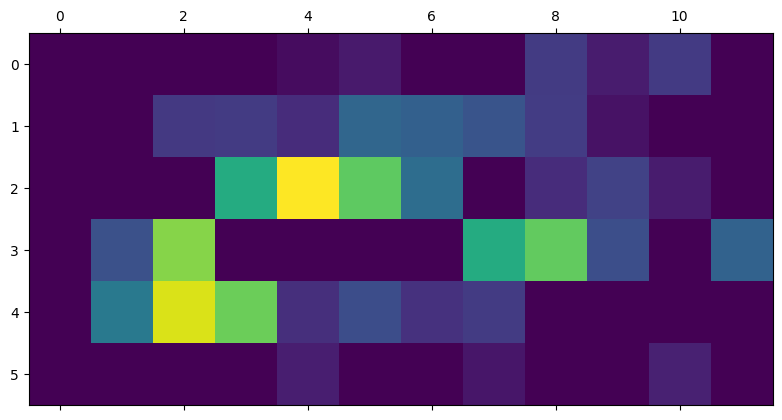

In [ ]:
# Load an example image
img_path = test_image_paths[8]
img_array = get_img_array(img_path)

# Use the pre-trained ViT model
model = vit_classifier

# Ensure the model does not use softmax in the last layer
model.layers[-1].activation = None

# Print the predicted class
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
print("Predicted class:", predicted_class)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="patch_encoder_1")

# Display the heatmap
plt.matshow(heatmap)
plt.show()


This cell defines a function to save and display the Grad-CAM heatmap superimposed on the original image. The function:

1. **Loading and Preprocessing**: Loads and preprocesses the original image using `gradcam_load_and_preprocess_image_for`.
2. **Heatmap Resizing**: Resizes the heatmap to match the size of the original image.
3. **Heatmap Conversion to RGB**: Converts the heatmap to RGB format using the Jet colormap.
4. **Image Creation with Heatmap**: Creates an image with the colorized heatmap in RGB format.
5. **Superimposing Heatmap**: Superimposes the heatmap on the original image by blending them.
6. **Saving the Image**: Saves the superimposed image to a specified path.
7. **Displaying Grad-CAM**: Displays the Grad-CAM using Matplotlib with a larger figure size and hides the axes for better visualization.


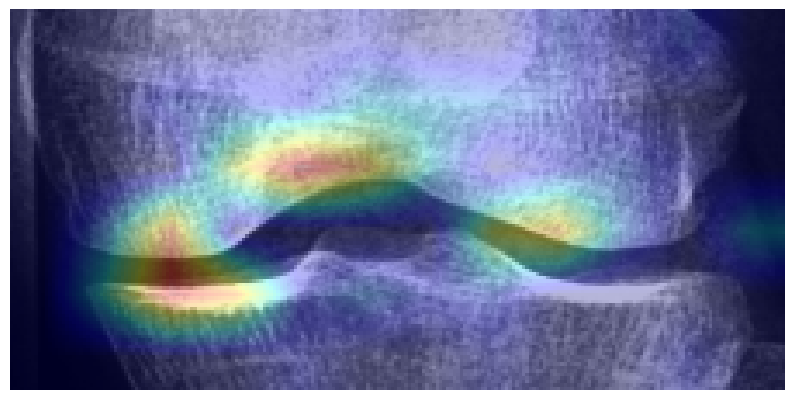

In [ ]:
# Function to save and display Grad-CAM
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load and preprocess the original image
    img = gradcam_load_and_preprocess_image_for(img_path)

    # Resize the heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)  # Normalize the heatmap to a range of 0-255
    jet = mpl.colormaps["jet"]  # Use the Jet colormap
    jet_colors = jet(np.arange(256))[:, :3]  # Extract the colors from the colormap
    jet_heatmap = jet_colors[heatmap]  # Apply the colormap to the heatmap

    # Create an image with the colorized heatmap in RGB format
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)  # Convert array to image
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize heatmap to match the original image
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)  # Convert image back to array

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img  # Blend the heatmap with the original image
    superimposed_img = keras.utils.array_to_img(superimposed_img)  # Convert the blended image to PIL format

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad-CAM using Matplotlib
    plt.figure(figsize=(10, 10))  # Set a larger figure size
    plt.imshow(superimposed_img)  # Display the superimposed image
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the image

# Save and display Grad-CAM
save_and_display_gradcam(img_path, heatmap)
